In [9]:
import torch

from rl4co.envs import TSPkoptEnv
from rl4co.models import NeuOptPolicy, NeuOpt
from rl4co.utils.trainer import RL4COTrainer

In [13]:
# RL4CO env based on TorchRL
env = TSPkoptEnv(generator_params={'num_loc': 20}, k_max=5)

policy = NeuOptPolicy(env_name=env.name)

model = NeuOpt(env, policy) 

In [ ]:
# Greedy rollouts over untrained policy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
policy = policy.to(device)
out = policy(td_init.clone(), env=env, phase="test", decode_type="greedy", return_actions=True)

actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['cost_bsf'].cpu().detach()

batch_size, seq_length = td_init["rec_current"].size()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

Batch size: 3, Sequence length: 20
Problem 1 | Cost: -9.748


ValueError: not enough values to unpack (expected 2, got 1)

In [4]:
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None,
)

Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/shora/Research/rl4co/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [5]:
trainer.fit(model)

val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                 | Params | Mode 
----------------------------------------------------------
0 | env      | TSPEnv               | 0      | train
1 | policy   | AttentionModelPolicy | 710 K  | train
2 | baseline | WarmupBaseline       | 710 K  | train
----------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.681     Total estimated model params size (MB)
72        Modules in train mode
68        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/shora/Research/rl4co/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/shora/Research/rl4co/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


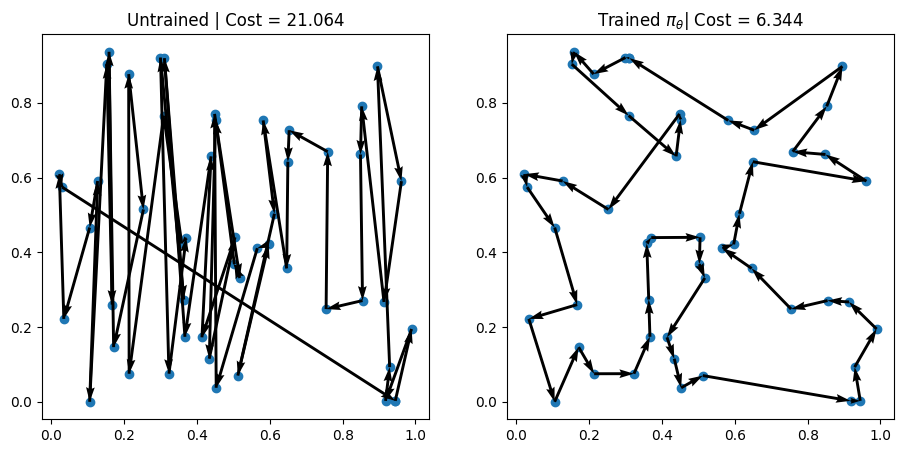

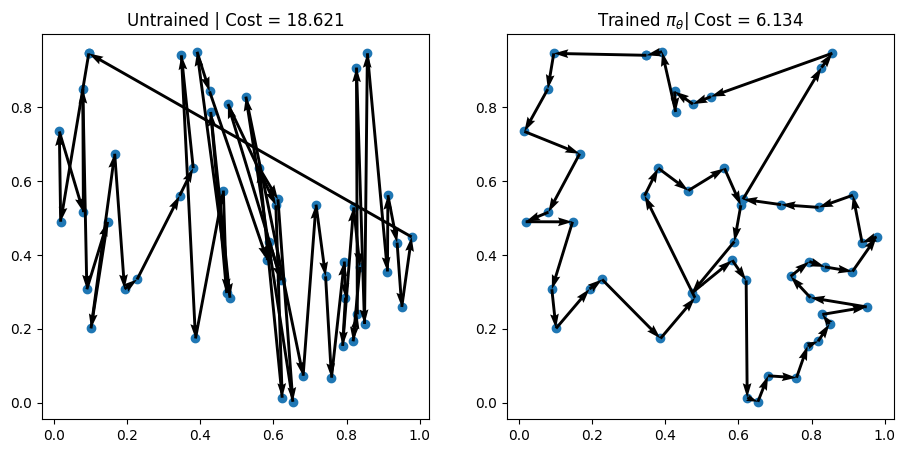

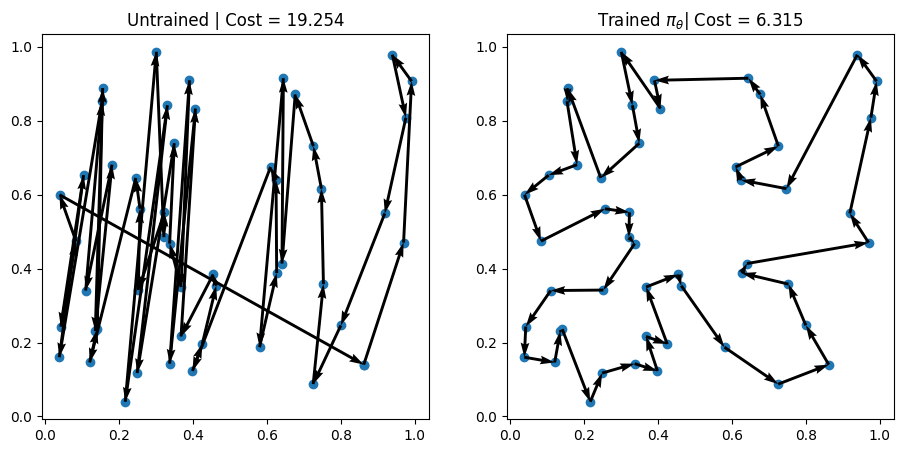

In [6]:
# Greedy rollouts over trained model (same states as previous plot)
policy = model.policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0]) 
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")